<h2>Speaker Encoder</h2>

In [1]:
import os
from pathlib import Path
import sys
import pandas as pd
import librosa as lr
import librosa.display as ld
import glob
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import nnabla as nn
import nnabla.parametric_functions as PF
import nnabla.functions as F
import nnabla.solvers as S
import tensorflow as tf
from nnabla.utils.data_iterator import data_iterator_simple
import nnabla.monitor as M

2020-12-08 20:33:15,898 [nnabla][INFO]: Initializing CPU extension...


In [2]:
############## Hyperparameters (to be moved to hparams.py)  #######################

### Directory Locations ###
#basedir = 'drive/My Drive/Colab Notebooks/SV2TTS'
data_dir = "./data/LJSpeech/"
label_dir = "./data/LJSpeech/labels/"
save_dir_mfcc = "./data/LJSpeech/mfcc/"
save_dir_transcripts = "./data/LJSpeech/transcripts/"

### FFT Parameters ###
sr = 22500
n_fft = 2048
hop_length = 512
n_mfcc = 13
mel_len = 290                      # frame length of mel spectrogram > Spectrogram is split into short-time frames
n_fft = 1024 
n_mels = 80                        # number of mel filters (number of Mel bands to generate)
hop_length = 256                   # audio samples between adjacent STFT columns
win_length = 1024                  # window length
mel_fmin = 0.0                     # minimum mel bank
mel_fmax = 8000                    # maximum mel bank
r = 3                              # number of frames generated on each timestep

### Model Parameters ###
batch_size = 20
lstm_layers = 3
lstm_hidden = 256
lstm_directions = 1
affine_hidden = 256
embed_size = 256

In [3]:
ys = np.load(label_dir + 's_id.npy')

In [4]:
len(ys)

9725

In [5]:
xs = []
mfccs = sorted(glob.glob(save_dir_mfcc + '*.npy'))
for i in tqdm(range(len(mfccs))):
    xs.append((np.load(mfccs[i])).T)
    

100%|██████████████████████████████████████████████████████████████████████████████| 9725/9725 [02:24<00:00, 67.23it/s]


In [6]:
np.array(xs).shape

(9725, 141, 13)

In [7]:
idx = {k: i for i, k in enumerate(sorted(set(ys)))}
print(idx)

{'LJ001': 0, 'LJ002': 1, 'LJ003': 2, 'LJ004': 3, 'LJ005': 4, 'LJ006': 5, 'LJ007': 6, 'LJ008': 7, 'LJ009': 8, 'LJ010': 9}


In [8]:
np.array(xs).shape

(9725, 141, 13)

In [9]:
''' 
Get total utterances for each speaker
'''

utter_count = {k: 0 for k in sorted(set(ys))}
mfccs = {k:[] for k in sorted(set(ys))}

for i, s_id in enumerate(ys):
    utter_count[s_id]+=1
    mfccs[s_id].append(xs[i])


In [10]:
print(utter_count)
for key in mfccs:
    print(np.array(mfccs[key]).shape)

{'LJ001': 598, 'LJ002': 1130, 'LJ003': 1201, 'LJ004': 816, 'LJ005': 989, 'LJ006': 1049, 'LJ007': 850, 'LJ008': 1031, 'LJ009': 973, 'LJ010': 1088}
(598, 141, 13)
(1130, 141, 13)
(1201, 141, 13)
(816, 141, 13)
(989, 141, 13)
(1049, 141, 13)
(850, 141, 13)
(1031, 141, 13)
(973, 141, 13)
(1088, 141, 13)


In [11]:
'''
Create customized dataset
'''
n_speakers = len(set(utter_count)) #number of speakers
n_utterances = 2 #utterances per batch
max_utter = utter_count[max(utter_count, key=utter_count.get)] 

dataset = []
labels = []

## Batch_size =20 , each batch will contain 2 utterances from each of the 10 speakers
def split_dataset(xs, ys):
    
    for i in tqdm(range(max_utter)):
        
        for s_id in utter_count:
            max_idx = utter_count[s_id] #Allow repeating data
            
            ## Appending n_utterances for each speaker (in one batch)
            for j in range(n_utterances):
                data = mfccs[s_id][(i+j)%max_idx]
                dataset.append(data)
                labels.append(s_id)
                
                
    return dataset,labels

dataset, labels = split_dataset(xs,ys)

100%|██████████████████████████████████████████████████████████████████████████| 1201/1201 [00:00<00:00, 109484.01it/s]


## Encoder Network

In [12]:
def encoder_network(inputs, training = False):
    with nn.parameter_scope('encoder_network/lstm'):
        h = nn.Variable((lstm_layers, lstm_directions, batch_size, lstm_hidden))
        c = nn.Variable((lstm_layers, lstm_directions, batch_size, lstm_hidden))
        
        y, hn, cn = PF.lstm(inputs, h, c, training = training)
    with nn.parameter_scope('encoder_network/dense'):
        #out = PF.affine(hn[-1], affine_hidden)
        #
        out = F.relu(hn[-1]) 
        #out.d = out.d/(np.linalg.norm(out.d))
    return out

In [13]:
def generate_batch(dataset,labels, batch_size):
    batch_data = dataset[:batch_size]
    batch_labels = labels[:batch_size]
    del dataset[:batch_size]
    del labels[:batch_size]
    dataset += batch_data
    labels += batch_labels
    batch_data = np.transpose(batch_data, (2,0,1) ) #convert shape from (B,I,T)  -> (T,B,I)
    return batch_data, np.array(batch_labels)

In [14]:
'''
Trainable parameteres for ths similarity matrix
'''

sim_weight = nn.Variable([1], need_grad = True)
sim_weight.d = 10.0
sim_bias = nn.Variable([1], need_grad = True)
sim_bias.d = -5.0

## Similarity Matrix

In [15]:
def similarity_matrix(embeddings):
    """
        Computes the similarity matrix according the section 2.1 of GE2E.
        :param embeds: the embeddings as a tensor of shape (speakers_per_batch, 
        utterances_per_speaker, embedding_size)
        :return: the similarity matrix as a tensor of shape (speakers_per_batch,
        utterances_per_speaker, speakers_per_batch)
        """
    embeddings = np.reshape(embeddings, [n_speakers, n_utterances, embed_size])
    centroids_incl = embeddings.mean(axis = 1, keepdims = True) # one centroid per speaker
    centroids_incl = centroids_incl/np.linalg.norm(centroids_incl, axis = 2, keepdims = True)
    centroids_excl = np.sum(embeddings, axis = 1, keepdims = True) - embeddings
    centroids_excl /= (n_utterances - 1)
    centroids_excl = centroids_excl/np.linalg.norm(centroids_excl, axis = 2, keepdims = True)
    sim_matrix = np.zeros((n_speakers, n_utterances, n_speakers), dtype = float)
    mask_matrix = 1 - np.eye(n_speakers, dtype = np.int)
    
    for j in range(n_speakers):
        mask = np.where(mask_matrix[j])[0]
        sim_matrix[mask, :, j] = (embeddings[mask] * centroids_incl[j]).sum(axis=2)
        sim_matrix[j, :, j] = (embeddings[j] * centroids_excl[j]).sum(axis=1)
    sim_matrix = sim_matrix * sim_weight.d + sim_bias.d
    return sim_matrix

In [16]:
def get_one_hot(targets, nb_classes):
    res = np.eye(nb_classes)[np.array(targets).reshape(-1)]
    return res.reshape(list(targets.shape)+[nb_classes])

## Loss Function

In [17]:
def loss_fn(embeddings):
    sim_matrix = similarity_matrix(embeddings.d)
    sim_matrix = sim_matrix.reshape((n_speakers * n_utterances, n_speakers))
    ground_truth = np.repeat(np.arange(n_speakers), n_utterances)
    ground_truth = ground_truth.reshape((n_speakers*n_utterances,1))
    #ground_truth = get_one_hot(ground_truth, n_speakers)
    shape1 = sim_matrix.shape
    shape2 = ground_truth.shape
    sm = nn.Variable(shape1)
    gt = nn.Variable(shape2)
    sm.d = sim_matrix
    gt.d = ground_truth
    loss = F.softmax_cross_entropy(sm,gt)    
    return loss

In [18]:
def forward(xs):
    embeds = encoder_network(xs, training = True)
    return embeds

## Training Loop

In [21]:
n_batch = len(dataset)//batch_size
max_epochs = 600

def train():
    monitor = M.Monitor('.')
    monitor_loss = M.MonitorSeries(
        "Training loss", monitor, interval=5000, verbose = True)
    monitor_time = M.MonitorTimeElapsed(
        "Training time", monitor, interval=10000, verbose = True)
    optimizer = S.RMSprop()
        
    for epoch in tqdm(range(max_epochs)):
        
        #Iterations per epoch
        
        for i in range(n_batch):
            xi = nn.Variable((13, batch_size, 141))            
            xi.d, yi = generate_batch(dataset,labels, batch_size)
            optimizer.zero_grad()
            embeddings = encoder_network(xi, True)
            loss = loss_fn(embeddings)
            loss.backward()
            optimizer.update()
        
            # monitor
            itr = epoch * n_batch + i
            monitor_loss.add(itr, loss.d)
            #monitor_time.add(itr)
        

In [22]:
train()

 27%|█████████████████████▌                                                          | 162/600 [09:39<25:39,  3.52s/it]2020-12-08 20:46:59,998 [nnabla][INFO]: iter=194999 {Training loss}=1.8276987843487221e+31


 54%|███████████████████████████████████████████▏                                    | 324/600 [19:22<16:49,  3.66s/it]2020-12-08 20:56:44,038 [nnabla][INFO]: iter=389999 {Training loss}=1.9731647480983093e+30


 81%|████████████████████████████████████████████████████████████████▉               | 487/600 [29:09<06:55,  3.68s/it]2020-12-08 21:06:28,394 [nnabla][INFO]: iter=584999 {Training loss}=2.155006012064819e+26


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [35:58<00:00,  3.60s/it]


In [ ]:
ground_truth = np.repeat(np.arange(n_speakers), n_utterances)

In [ ]:
ground_truth.reshape((1,n_speakers*n_utterances))

In [49]:
test_batch, test_labels = generate_batch(dataset, labels, batch_size)

In [24]:
test_batch_var = nn.Variable((13, batch_size, 141))
test_batch_var.d = test_batch
inferences = encoder_network(test_batch_var)

In [25]:
inferences.d[0, 1]

array([0.0000000e+00, 0.0000000e+00, 1.4012985e-45, 1.4012985e-45,
       2.8025969e-45, 2.8025969e-45, 4.2038954e-45, 4.2038954e-45,
       5.6051939e-45, 5.6051939e-45, 7.0064923e-45, 7.0064923e-45,
       8.4077908e-45, 8.4077908e-45, 9.8090893e-45, 9.8090893e-45,
       1.1210388e-44, 1.1210388e-44, 1.2611686e-44, 1.2611686e-44,
       3.6327112e-01, 3.5967740e-01, 4.4778126e-01, 3.5888508e-01,
       2.3095544e-01, 1.6854915e-01, 1.7704542e-01, 1.5365802e-01,
       1.0272297e-01, 2.9998496e-01, 4.0747026e-01, 3.3507711e-01,
       2.8603339e-01, 3.2031783e-01, 3.7857255e-01, 3.5380346e-01,
       3.0281183e-01, 2.8828996e-01, 2.7170804e-01, 2.4931201e-01,
       3.1725082e-01, 3.7840536e-01, 4.2192289e-01, 4.0436459e-01,
       4.4591850e-01, 4.7905219e-01, 4.1939542e-01, 3.5325915e-01,
       3.9275444e-01, 4.2455089e-01, 4.0084928e-01, 3.2496920e-01,
       1.9948927e-01, 1.6811277e-01, 1.1786614e-01, 1.1500115e-01,
       1.5209943e-01, 1.9923288e-01, 2.4022564e-01, 2.2183426e

In [32]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(inferences.d[0])

[t-SNE] Computing 19 nearest neighbors...
[t-SNE] Indexed 20 samples in 0.000s...
[t-SNE] Computed neighbors for 20 samples in 0.390s...
[t-SNE] Computed conditional probabilities for sample 20 / 20
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.074280
[t-SNE] KL divergence after 300 iterations: 0.585815


In [43]:
tsne_results.shape

(20, 2)

In [38]:
import pandas as pd
import seaborn as sns

In [53]:
list(test_labels)

['LJ001',
 'LJ001',
 'LJ002',
 'LJ002',
 'LJ003',
 'LJ003',
 'LJ004',
 'LJ004',
 'LJ005',
 'LJ005',
 'LJ006',
 'LJ006',
 'LJ007',
 'LJ007',
 'LJ008',
 'LJ008',
 'LJ009',
 'LJ009',
 'LJ010',
 'LJ010']

In [57]:
df = pd.DataFrame(tsne_results)
df.insert(2,"ID",list(test_labels))
df.columns = ["x","y","id"]
df

,x,y,id
0,7.107192,-79.457039,LJ001
1,-48.487328,-48.236965,LJ001
2,40.088055,61.684921,LJ002
3,-22.299587,118.799965,LJ002
4,-27.051081,-137.276535,LJ003
5,113.547966,70.017235,LJ003
6,-57.199474,-214.560883,LJ004
7,-134.935043,-197.974060,LJ004
8,-171.150848,-21.534975,LJ005
9,-70.680634,45.647087,LJ005


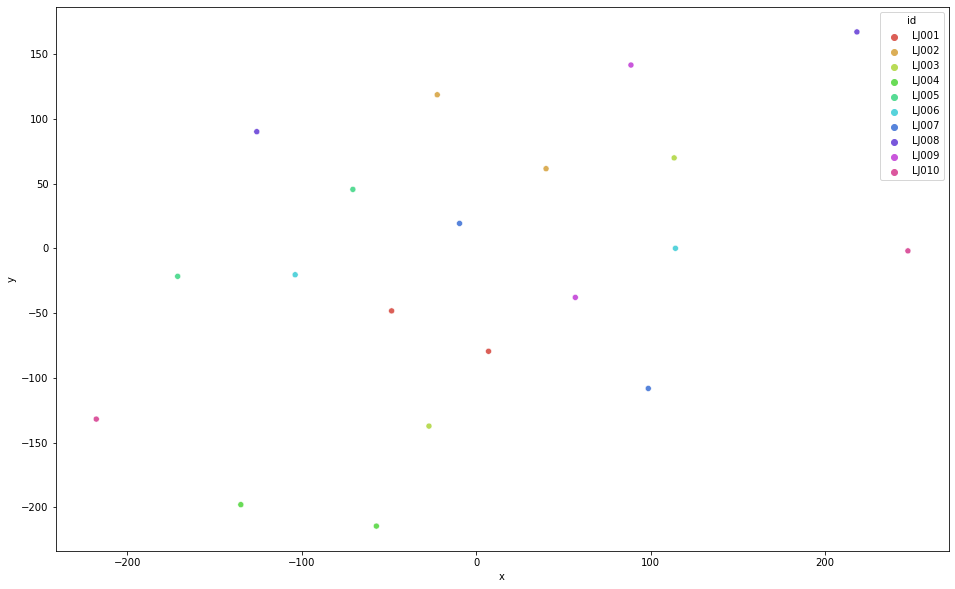

In [60]:
data = tsne_results

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="x", y="y",
    hue="id",
    palette=sns.color_palette("hls", 10),
    data= df,
    legend="full",
    alpha=1
)

In [41]:
data = inferences.d[0]


(256,)

array([ 0.00000000e+00,  0.00000000e+00,  1.40129846e-45,  1.40129846e-45,
        2.80259693e-45,  2.80259693e-45,  4.20389539e-45,  4.20389539e-45,
        5.60519386e-45,  5.60519386e-45,  7.00649232e-45,  7.00649232e-45,
        8.40779079e-45,  8.40779079e-45,  9.80908925e-45,  9.80908925e-45,
        1.12103877e-44,  1.12103877e-44,  1.26116862e-44,  1.26116862e-44,
        2.43608996e-01,  2.66062558e-01,  3.06599736e-01,  2.83012867e-01,
        2.68361866e-01,  2.65376657e-01,  1.53422967e-01,  1.17901772e-01,
       -8.04981887e-02, -7.36958310e-02, -1.84764061e-02, -6.90907706e-03,
       -2.11369824e-02,  5.33500947e-02,  8.54951516e-02,  5.46493046e-02,
        6.05032556e-02,  1.41173169e-01,  1.33467585e-01,  1.26213968e-01,
        1.33231267e-01,  1.38954863e-01,  1.30715370e-01,  6.57021180e-02,
        1.23611085e-01,  1.51095331e-01,  2.50834048e-01,  3.80779177e-01,
        3.10016394e-01,  2.56708682e-01,  2.48015940e-01,  2.33545348e-01,
        1.97218210e-01,  